<a href="https://colab.research.google.com/github/VardhanVelamakanni/Mental_stress_Prediction_V2/blob/main/Pipeline6TOPOMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [2]:
import zipfile, os

zip_name = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_name,'r') as zip_ref:
    zip_ref.extractall("/content/stew")

print(os.listdir("/content/stew"))


['dataset.mat', 'three_class_one_hot.mat', 'class_012.mat', 'rating.mat', 'EEG data summary.pdf']


In [3]:
!pip install mne scipy numpy torch tqdm scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 83.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import scipy.io as sio
import mne
import os
import torch

from scipy.signal import butter, filtfilt
from scipy.interpolate import griddata
from tqdm import tqdm


In [5]:
data = sio.loadmat("/content/stew/dataset.mat")['dataset']
labels = sio.loadmat("/content/stew/class_012.mat")['class_012']

print(data.shape)    # (14,19200,45)
print(labels.shape)


(14, 19200, 45)
(45, 1)


In [6]:
ch_names = ['AF3','F7','F3','FC5','T7','P7','O1',
            'O2','P8','T8','FC6','F4','F8','AF4']

info = mne.create_info(ch_names=ch_names, sfreq=128, ch_types='eeg')
montage = mne.channels.make_standard_montage("standard_1020")
info.set_montage(montage)


<Info | 8 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>

In [7]:
def bandpass(sig, low, high, fs=128, order=4):
    nyq = fs/2
    b,a = butter(order,[low/nyq, high/nyq],btype='band')
    return filtfilt(b,a,sig)


In [8]:
from mne.channels.layout import _find_topomap_coords

pos = _find_topomap_coords(info, picks=range(14))

grid_x, grid_y = np.mgrid[-0.5:0.5:32j, -0.5:0.5:32j]

def topomap_grid(values):
    zi = griddata(pos, values, (grid_x, grid_y), method='cubic', fill_value=0)
    return zi


In [9]:
os.makedirs("/content/topogrids", exist_ok=True)


In [10]:
bands = [(1,4),(4,8),(8,13),(13,30),(30,45)]
window = 256

idx = 0
label_list = []

total = 45*(19200//window)
pbar = tqdm(total=total)

for subj in range(45):

    eeg = data[:,:,subj]
    label = labels[subj][0]

    for i in range(0,19200-window,window):

        segment = eeg[:,i:i+window]
        segment = (segment-segment.mean())/(segment.std()+1e-6)

        grids = []

        for (l,h) in bands:
            filtered = np.array([
                bandpass(segment[ch],l,h)
                for ch in range(14)
            ])

            power = np.mean(filtered**2,axis=1)
            rel = power/(np.sum(power)+1e-8)
            grid = topomap_grid(rel)
            grids.append(grid)

        fused = np.stack(grids,axis=-1)  # (32,32,5)

        np.save(f"/content/topogrids/sample_{idx}.npy", fused)
        label_list.append(label)

        idx+=1
        pbar.update(1)

pbar.close()

np.save("/content/topogrids/labels.npy", np.array(label_list))


 99%|█████████▊| 3330/3375 [04:17<00:03, 12.93it/s]


(32, 32, 5)


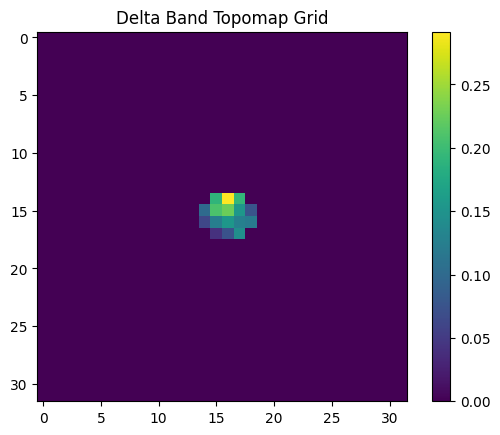

In [11]:
import matplotlib.pyplot as plt

sample = np.load("/content/topogrids/sample_0.npy")
print(sample.shape)   # (32,32,5)

plt.imshow(sample[:,:,0])
plt.title("Delta Band Topomap Grid")
plt.colorbar()
plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt

sample = np.load("/content/topogrids/sample_0.npy")
print(sample.shape)   # (32,32,5)


(32, 32, 5)


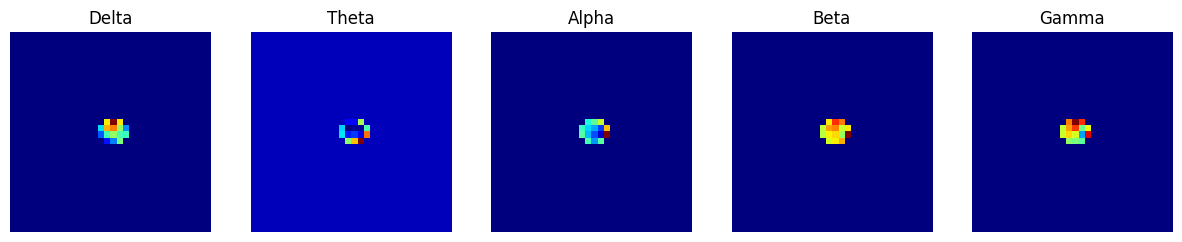

In [13]:
band_names = ['Delta','Theta','Alpha','Beta','Gamma']

fig, axes = plt.subplots(1,5, figsize=(15,3))

for i in range(5):
    axes[i].imshow(sample[:,:,i], cmap='jet')
    axes[i].set_title(band_names[i])
    axes[i].axis("off")

plt.show()


In [14]:
!zip -r topogrid_dataset.zip /content/topogrids


  adding: content/topogrids/ (stored 0%)
  adding: content/topogrids/sample_2219.npy (deflated 98%)
  adding: content/topogrids/sample_1336.npy (deflated 98%)
  adding: content/topogrids/sample_1838.npy (deflated 98%)
  adding: content/topogrids/sample_3101.npy (deflated 98%)
  adding: content/topogrids/sample_1102.npy (deflated 98%)
  adding: content/topogrids/sample_2618.npy (deflated 98%)
  adding: content/topogrids/sample_2307.npy (deflated 98%)
  adding: content/topogrids/sample_2103.npy (deflated 98%)
  adding: content/topogrids/sample_2968.npy (deflated 98%)
  adding: content/topogrids/sample_1601.npy (deflated 98%)
  adding: content/topogrids/sample_1521.npy (deflated 98%)
  adding: content/topogrids/sample_2467.npy (deflated 98%)
  adding: content/topogrids/sample_1067.npy (deflated 98%)
  adding: content/topogrids/sample_2497.npy (deflated 98%)
  adding: content/topogrids/sample_264.npy (deflated 98%)
  adding: content/topogrids/sample_3032.npy (deflated 98%)
  adding: conten

In [15]:
from google.colab import files
files.download("topogrid_dataset.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>